In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from data_visualisation import *
from data_filtration import *
import matplotlib.image as mpimg
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df = df[df.UUID == 'b9407f30f5f8466eaff925556b57fe6d']

In [4]:
straight_line = df[df.SessId == 32]
standing_still = df[df.SessId == 31]

In [5]:
df = df[df.SessId != 32]
df = df[df.SessId != 31]

In [6]:
img = mpimg.imread('cropped_flat.png')

In [7]:
beacons = pd.DataFrame(
    {
        'Minor' : [
            "9619",
            "9617",
            "9609",
            "9616",
            "9618",
        ],
        'X' : [13.7,
               13.4,
               8.4,
               6.2,
               0.3,
              ],
        'Y' : [1.6,
               6.5,
               7.0,
               0.2,
               5.2,
              ],
    }
)

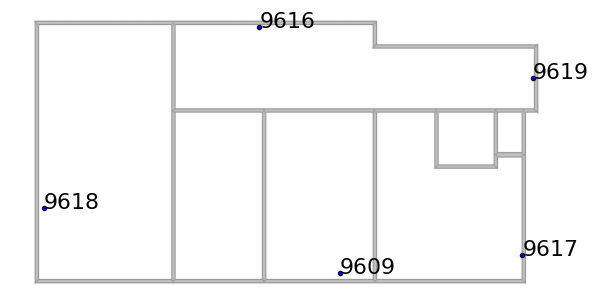

In [8]:
plt.figure(figsize=(10, 7))
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.imshow(img)
plot_beacons(beacons, img)

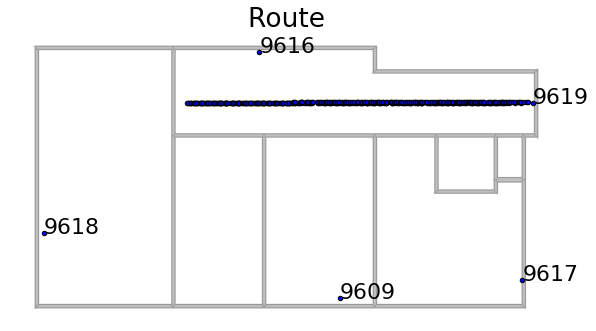

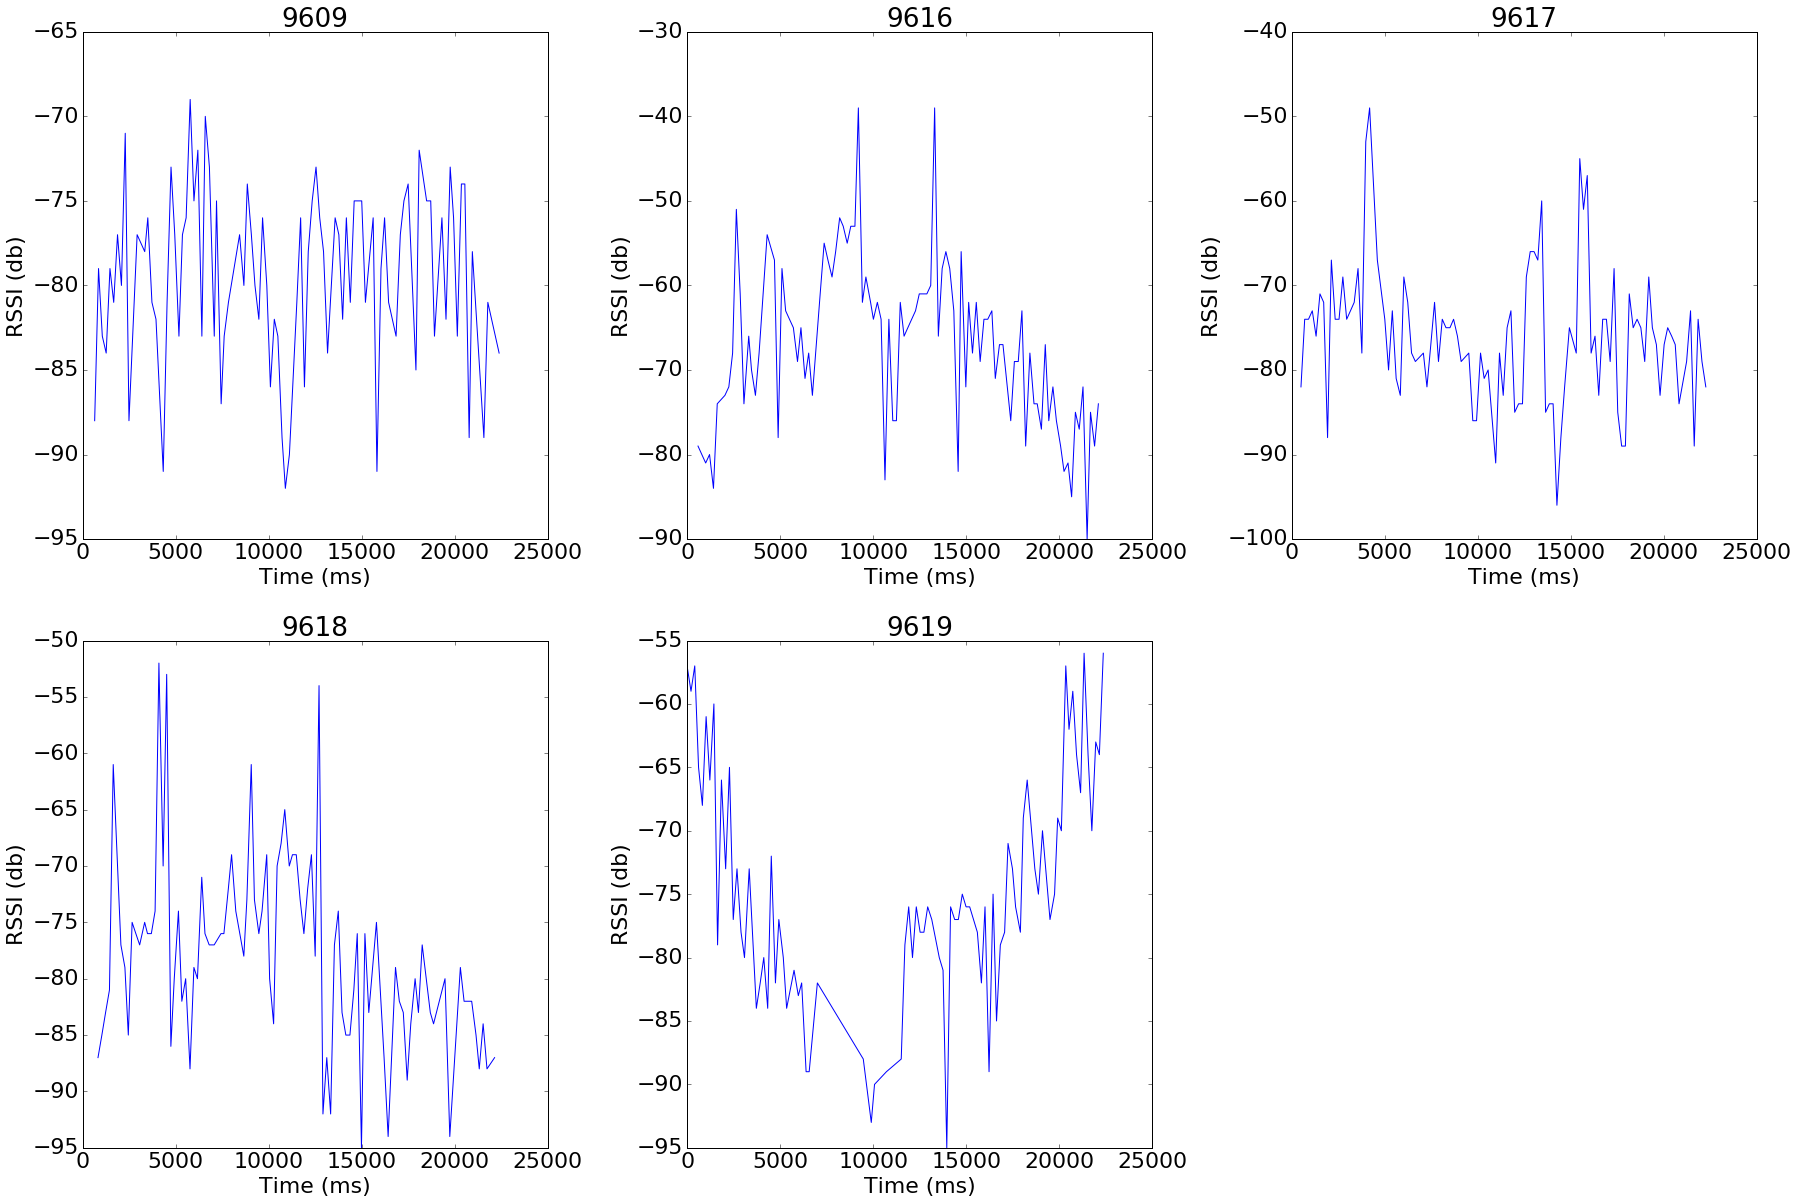

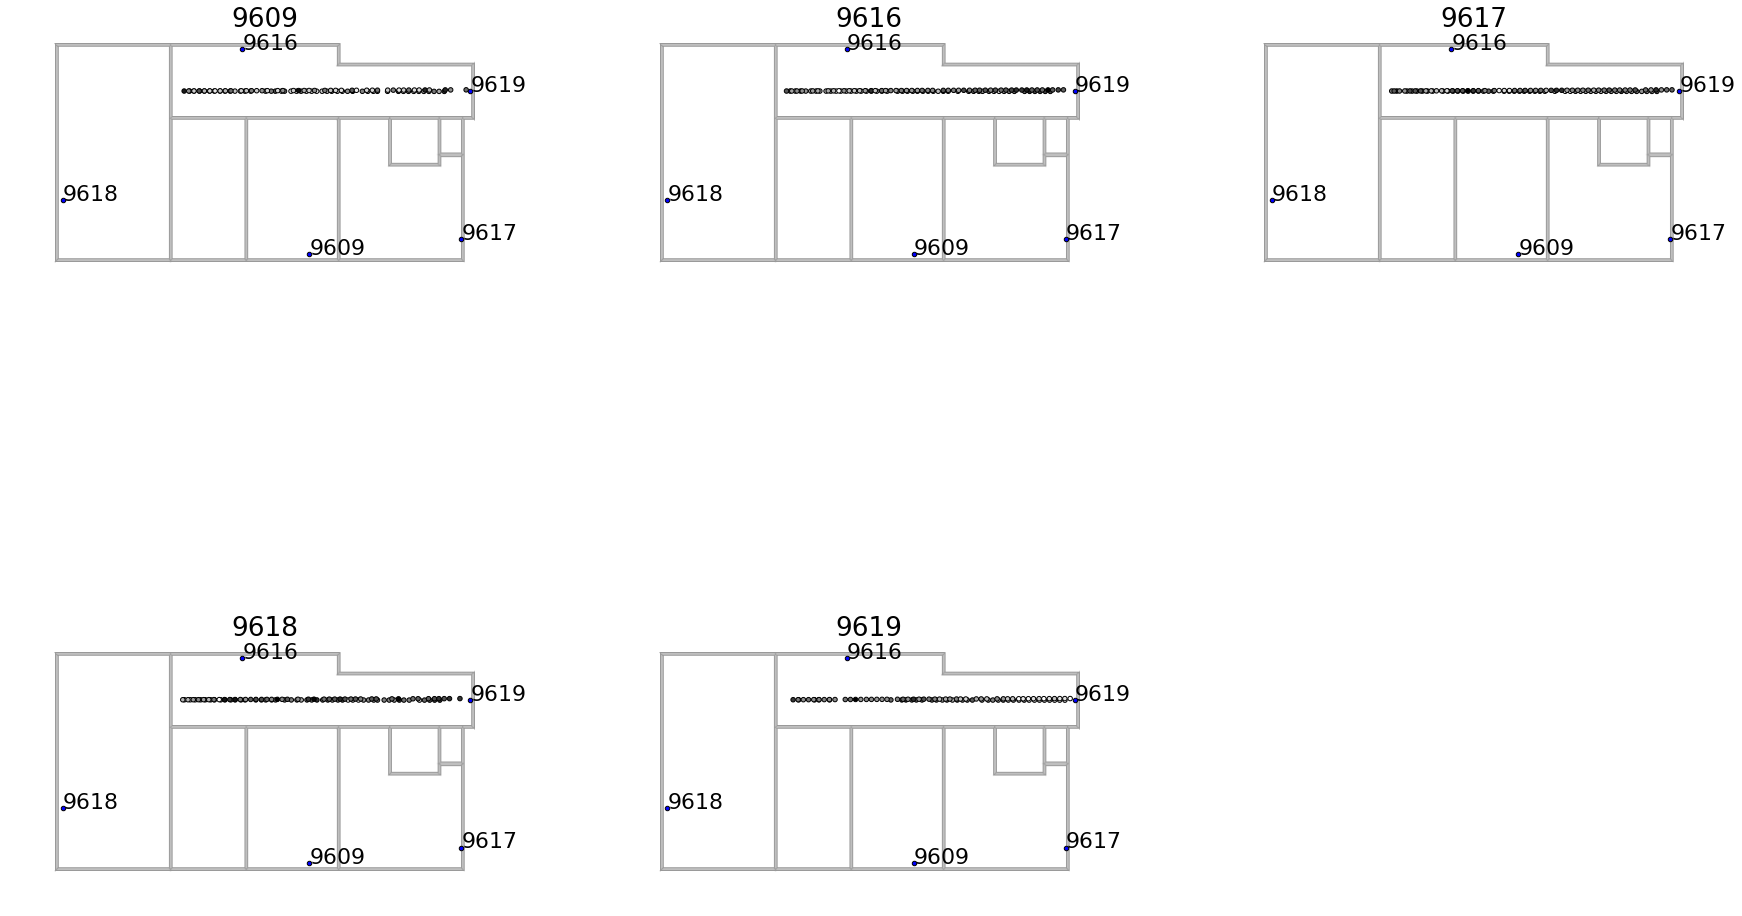

In [9]:
plot_session(straight_line, img, beacons=beacons)

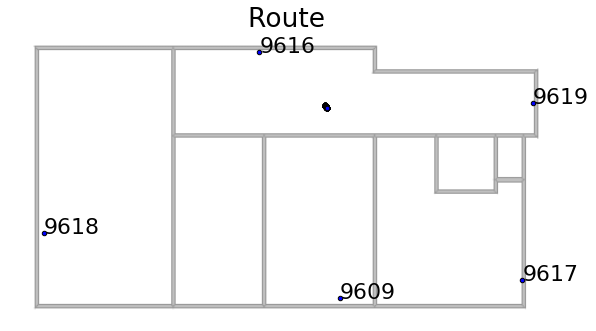

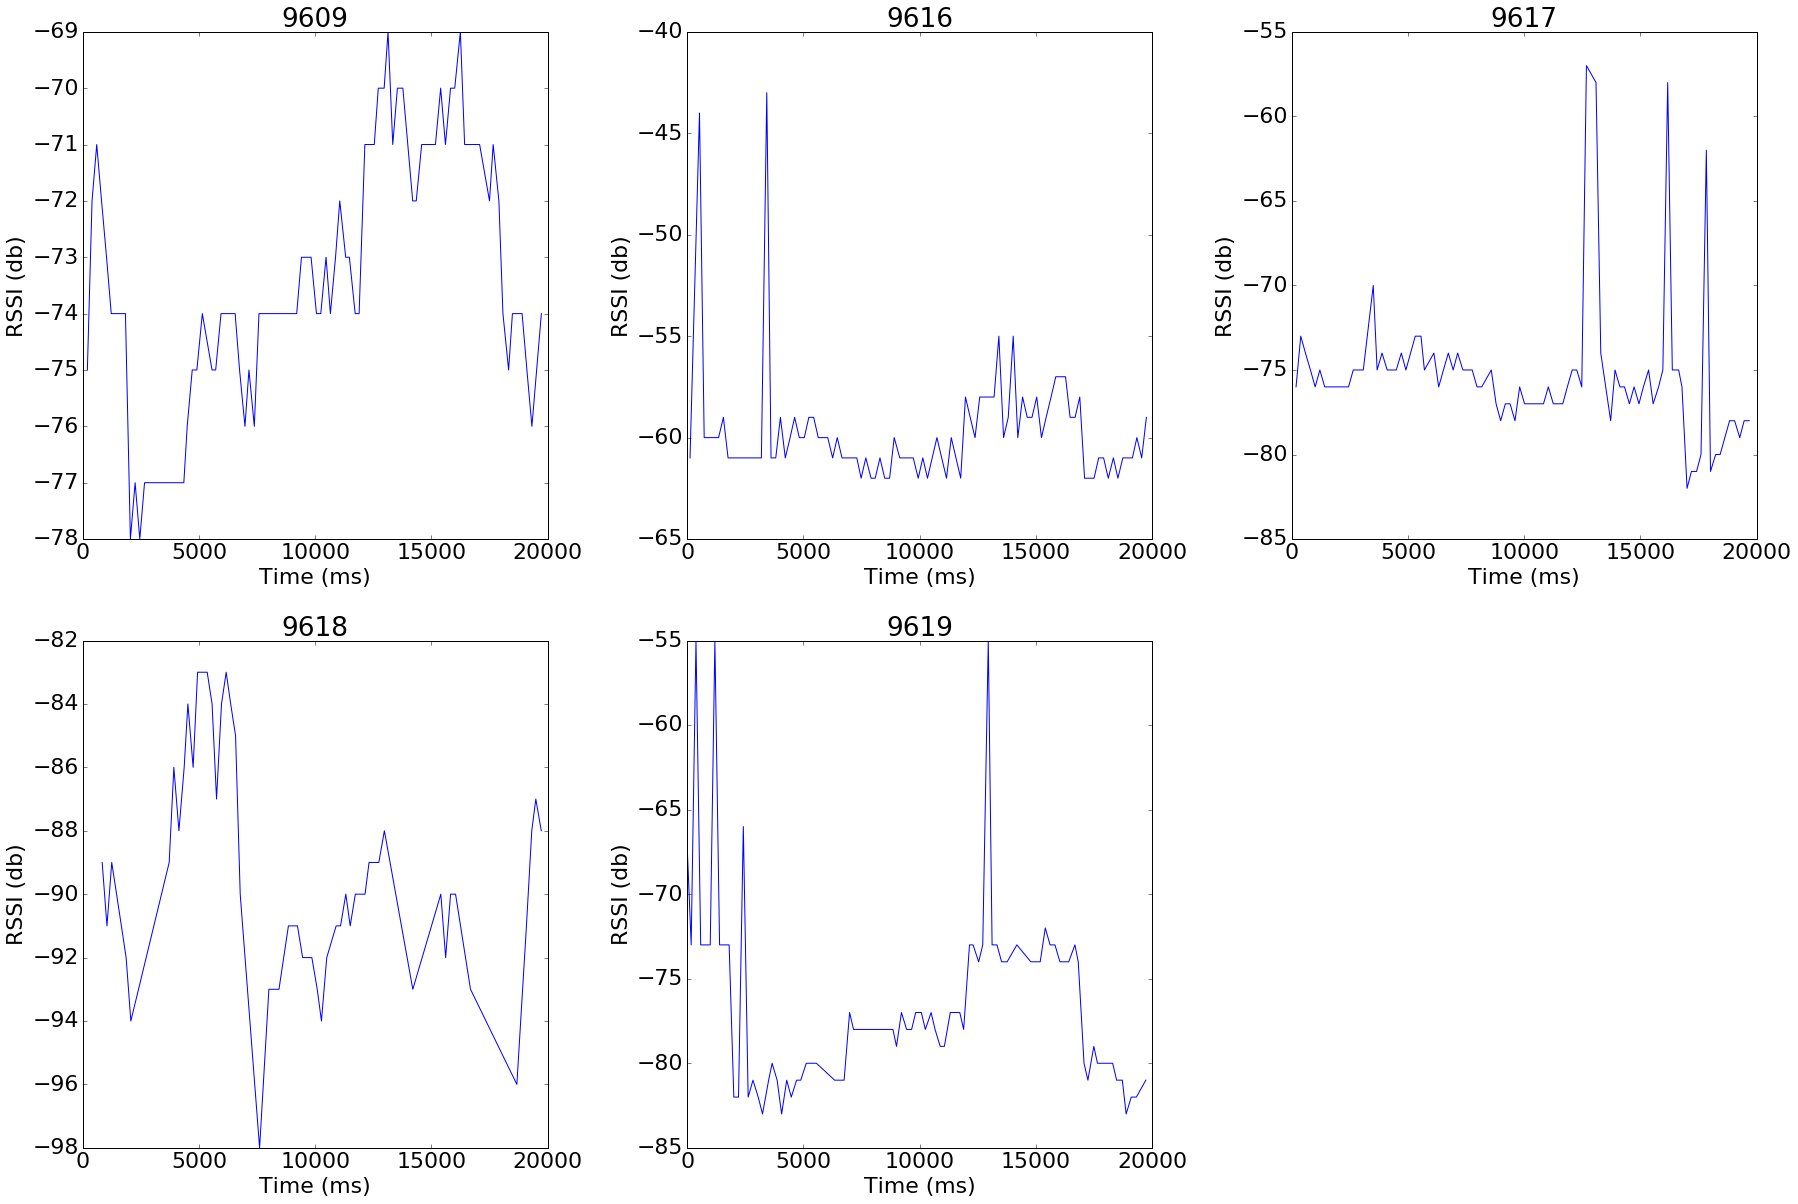

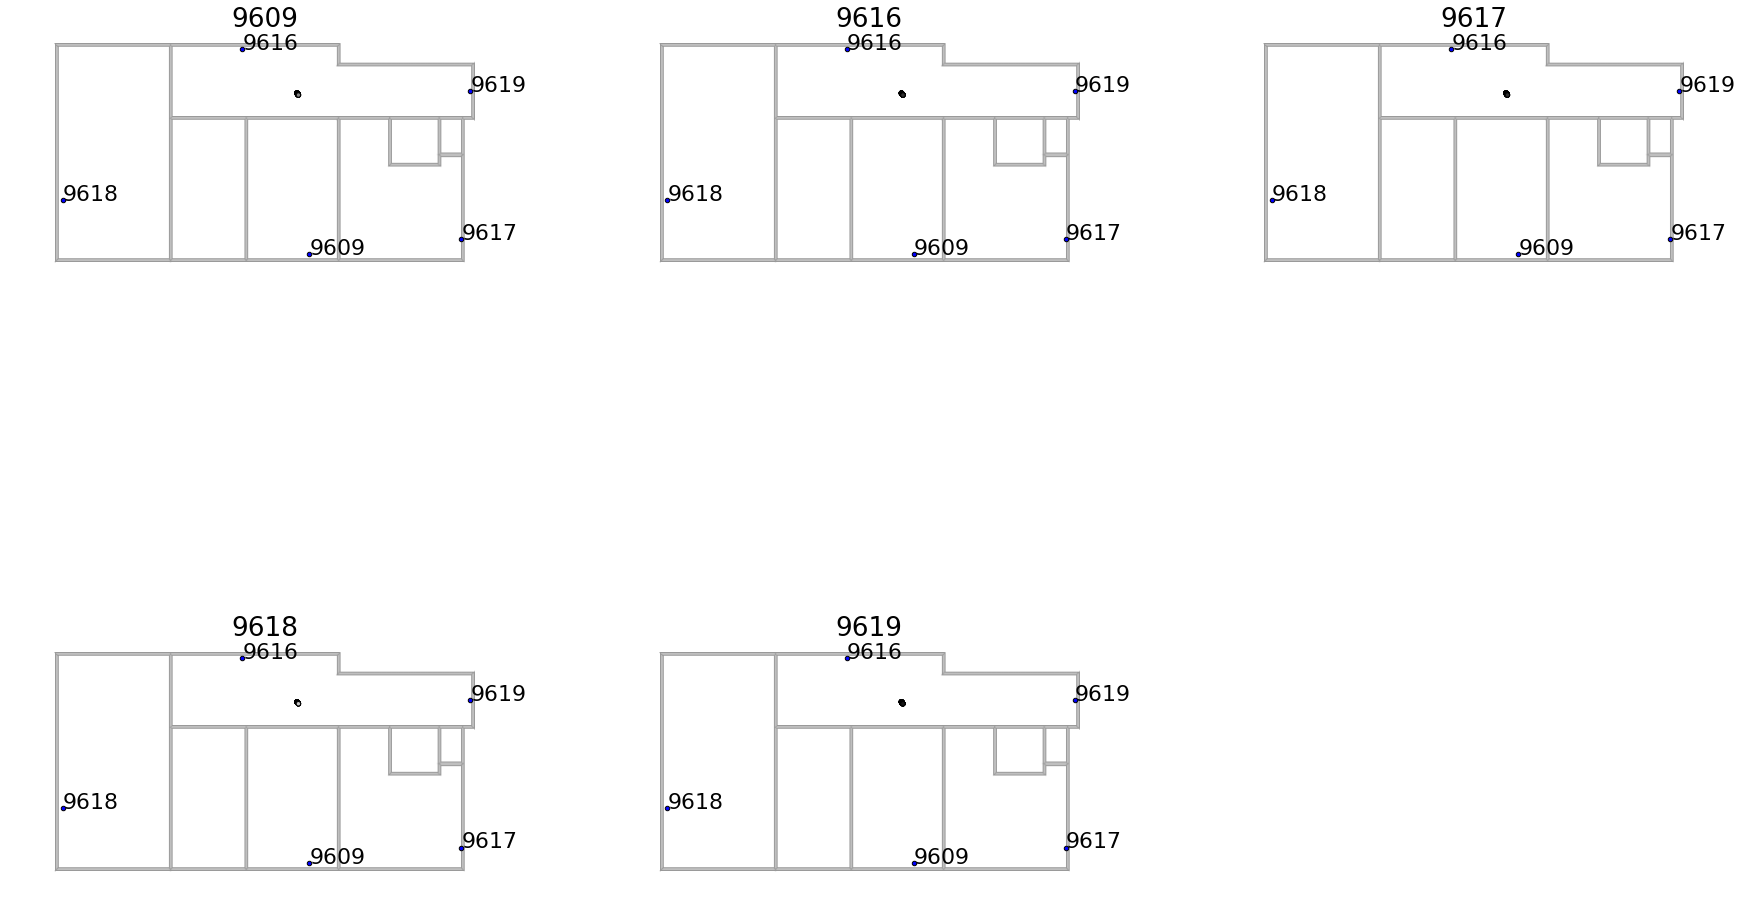

In [10]:
plot_session(standing_still, img, beacons=beacons)

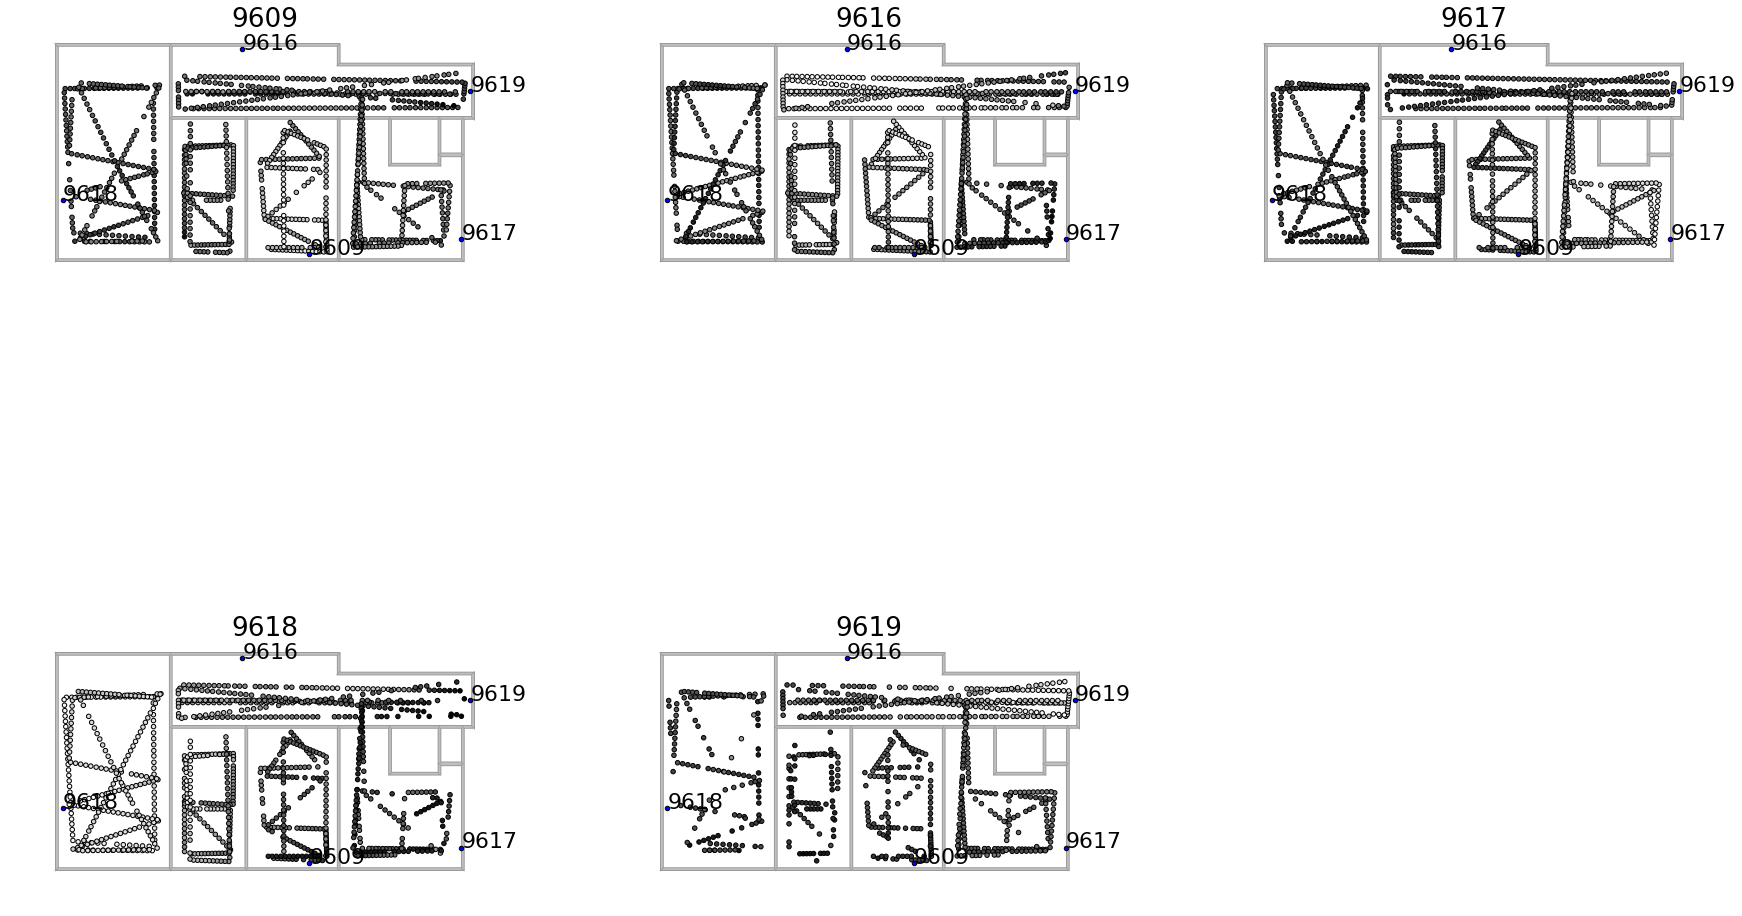

In [11]:
plot_rssi_map(filter_rssi_df(df, filter_func=create_rssi_avg_filter(17)), img, beacons=beacons)

In [12]:
def print_per_minor_stats(df):
    minors = sorted(df.Minor.unique())
    for minor in minors:
        print("**Minor {}".format(minor))
        print(df[df.Minor == minor].RSSI.describe(),"\n\n")
    

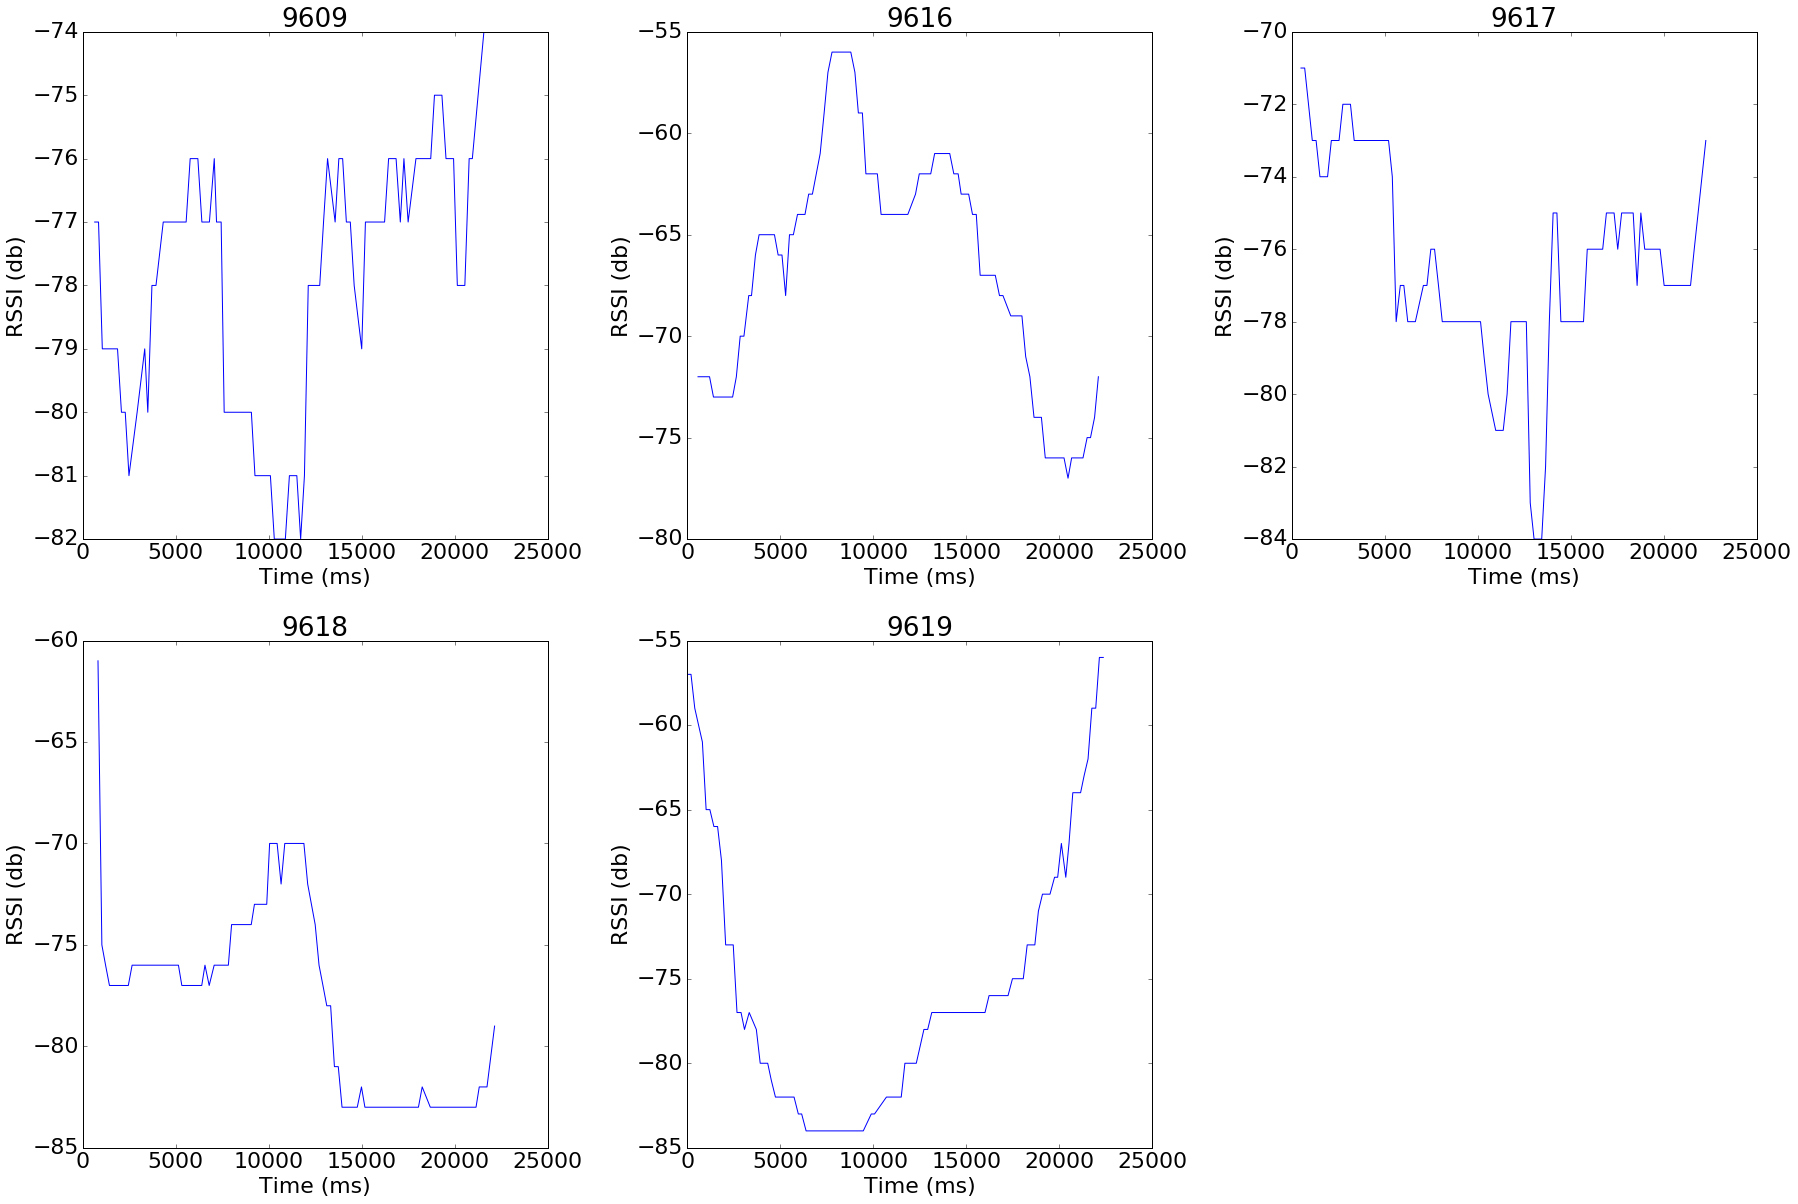

In [15]:
plot_rssi_data(straight_line, filter_func=create_rssi_median_filter(15))

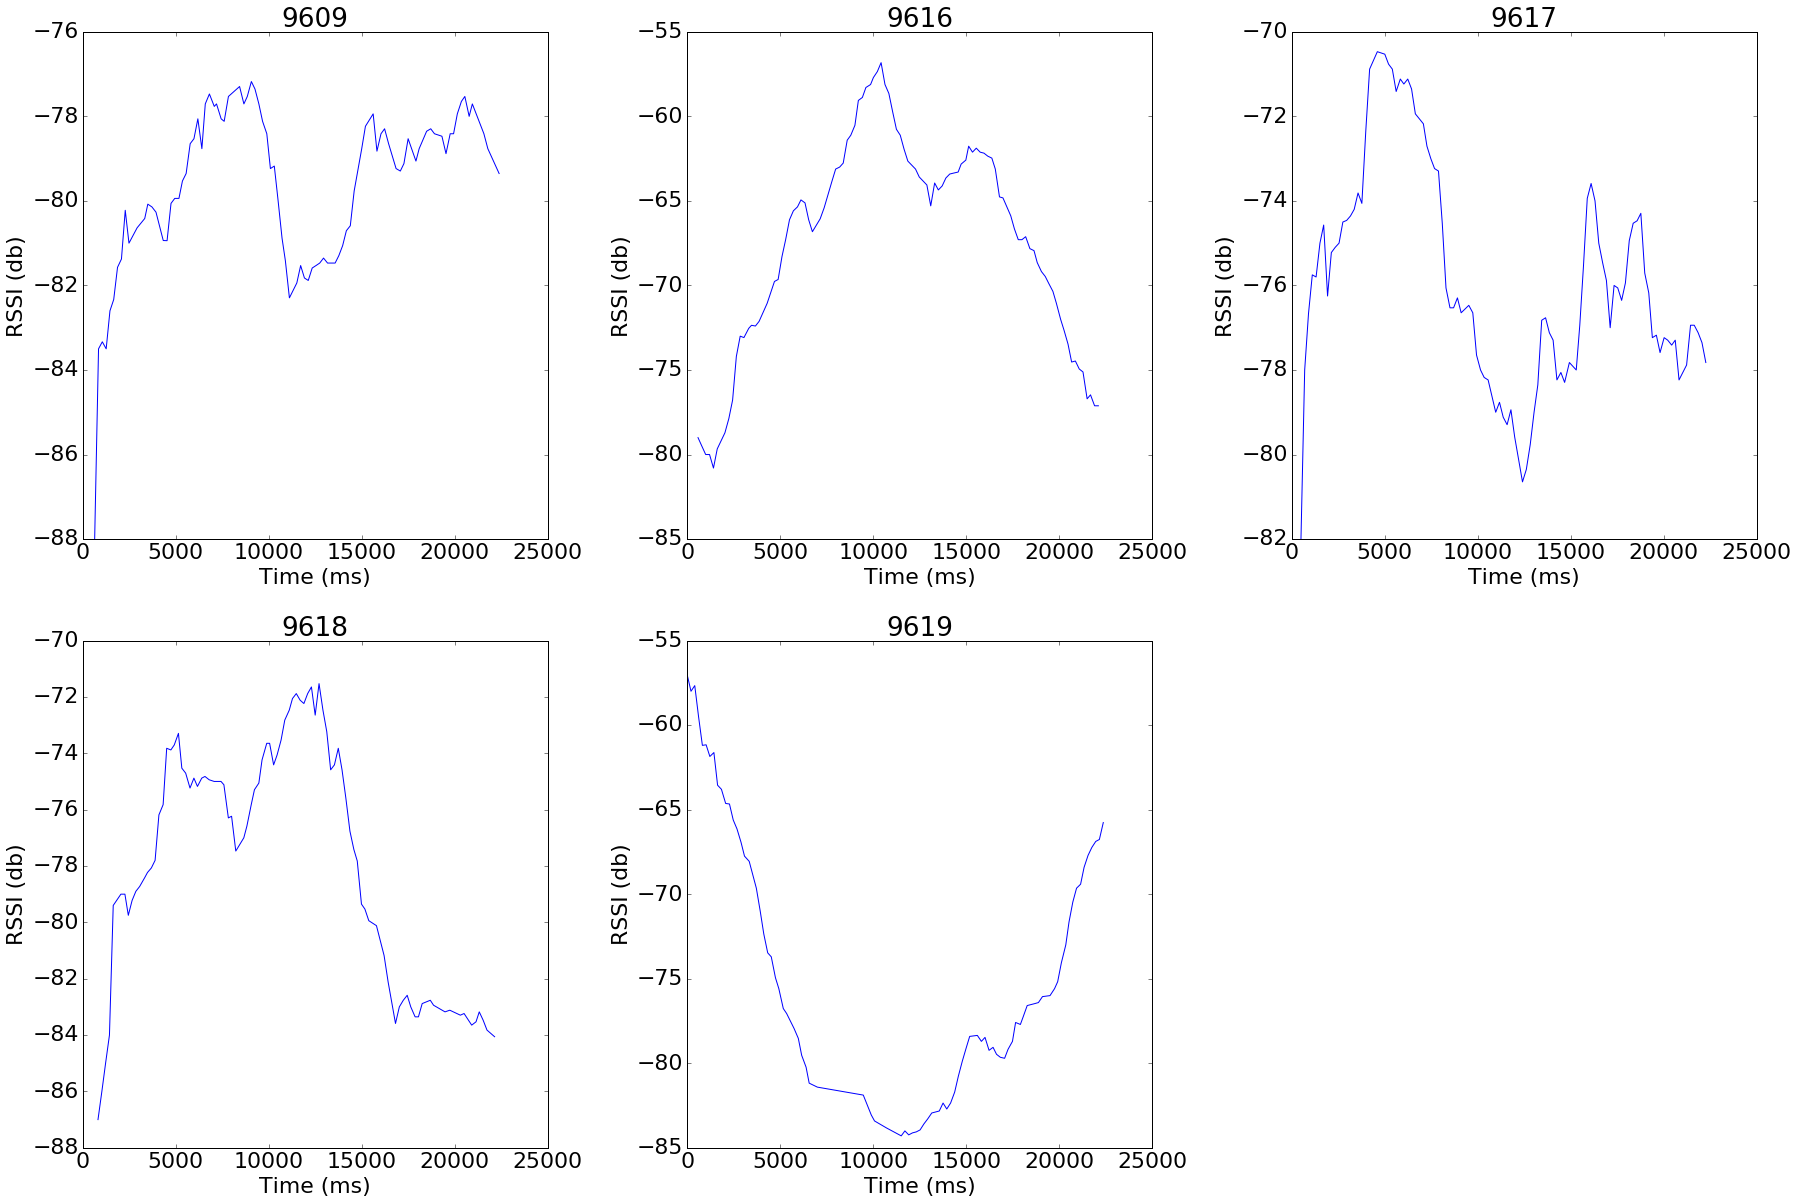

In [16]:
plot_rssi_data(straight_line, filter_func=create_rssi_avg_filter(17))

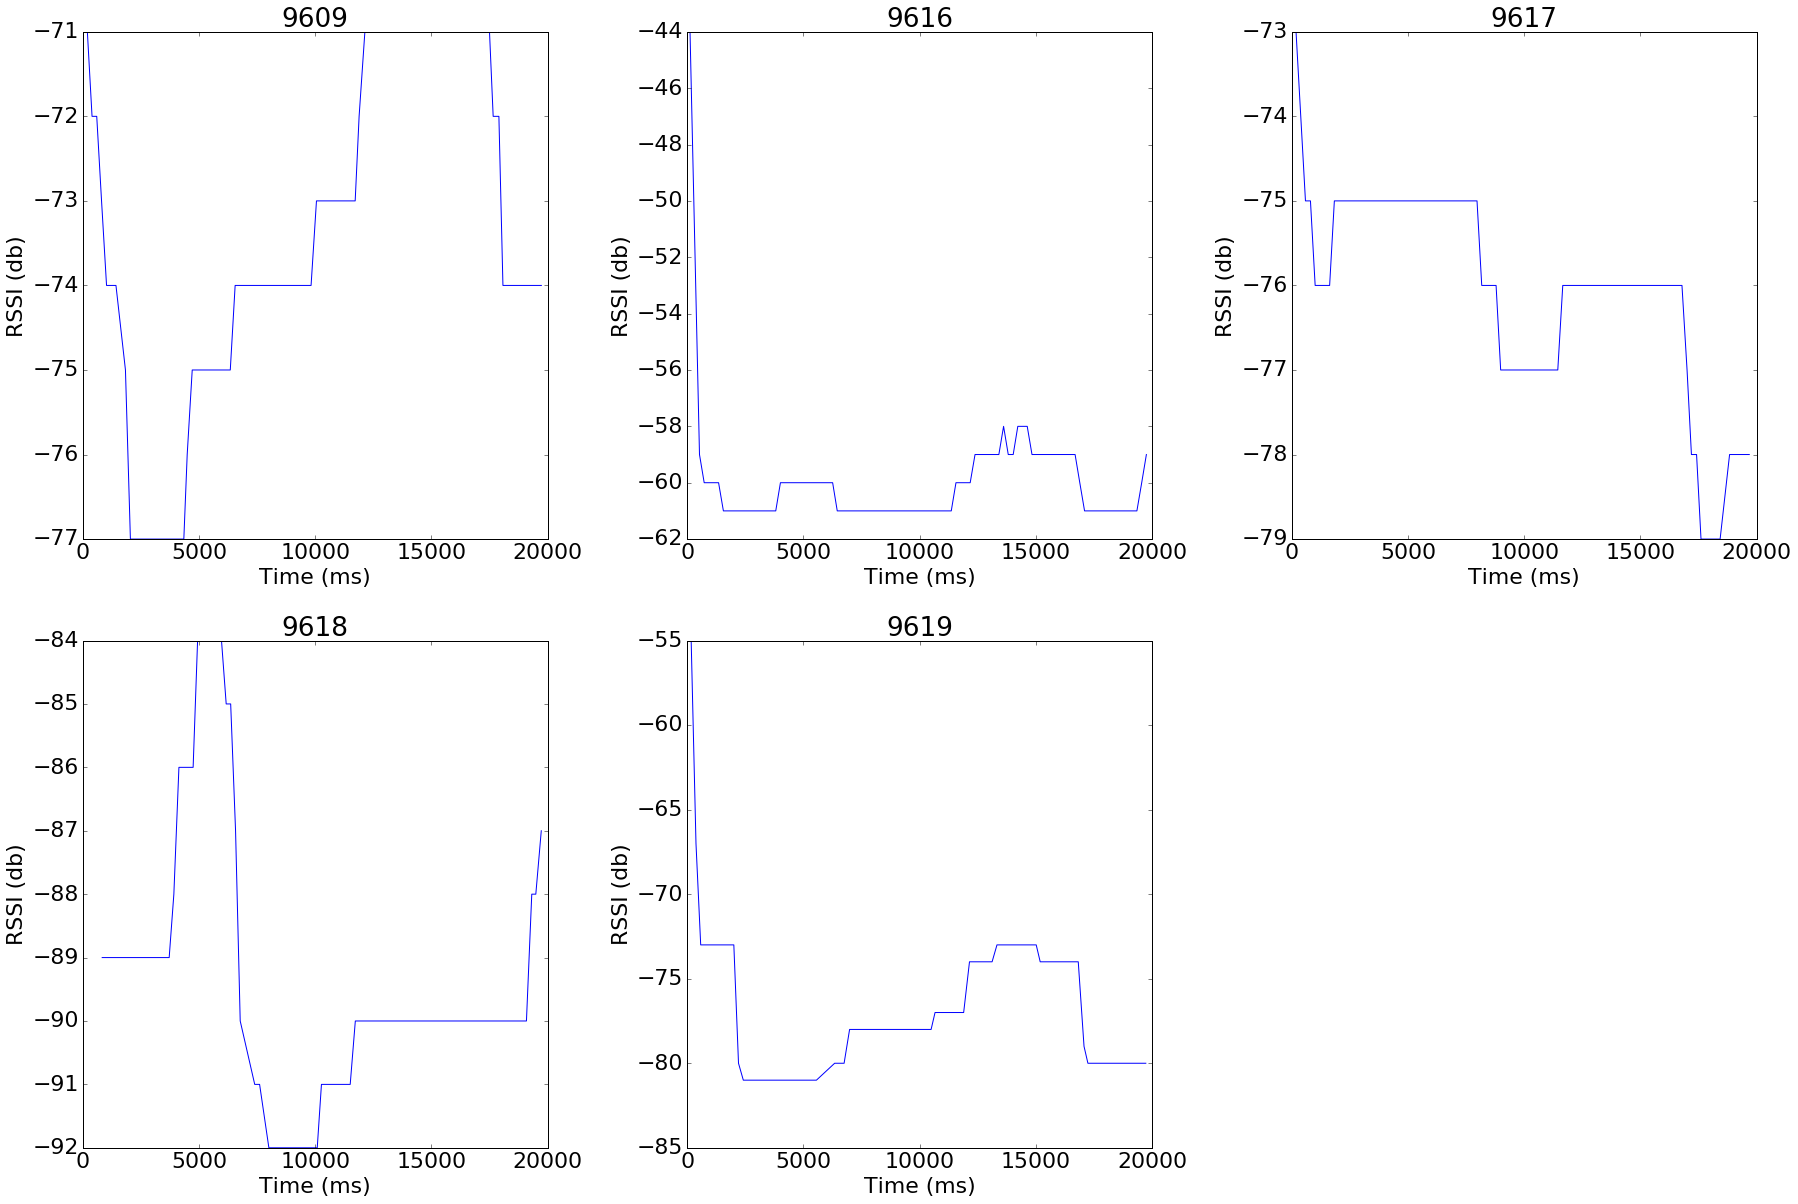

In [17]:
plot_rssi_data(standing_still, filter_func=create_rssi_median_filter(kernel=15))

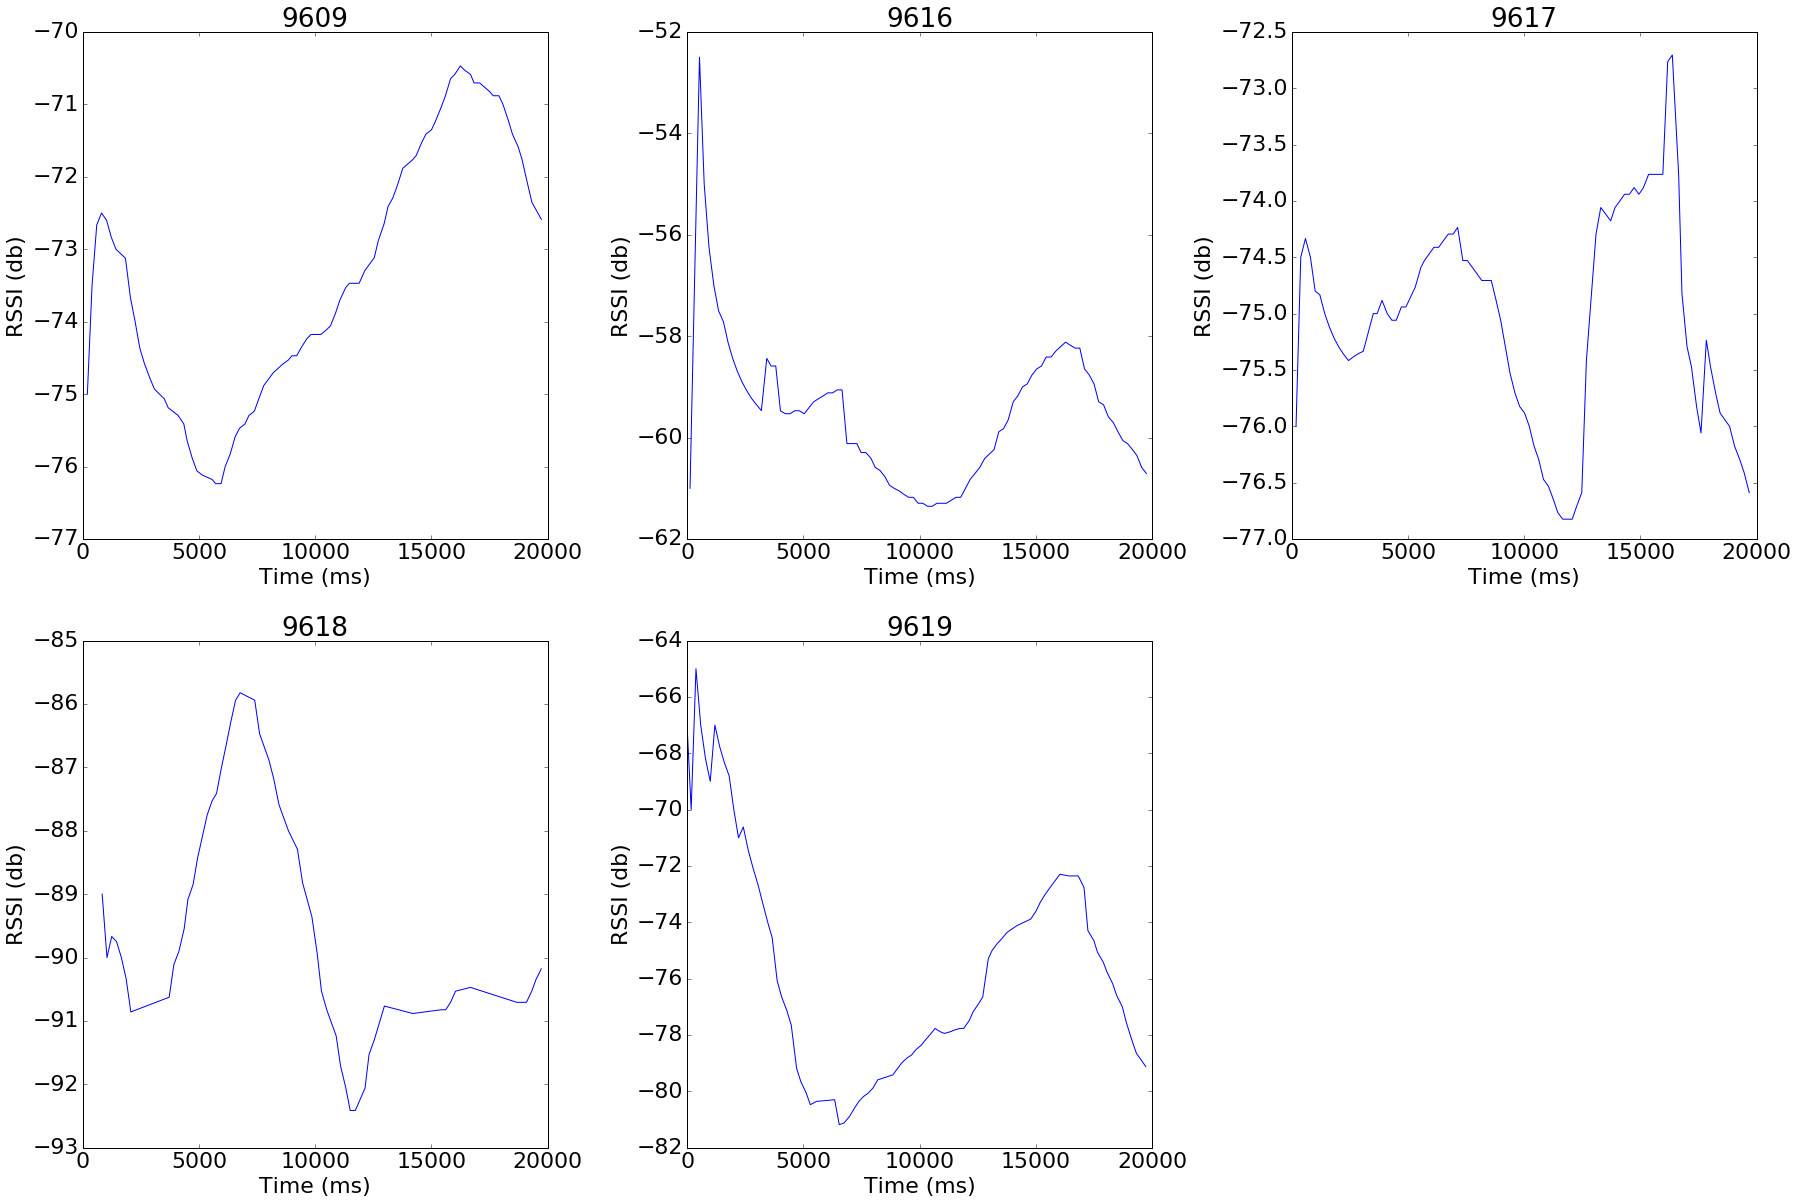

In [18]:
plot_rssi_data(standing_still, filter_func=create_rssi_avg_filter(kernel=17))

In [19]:
def filter_std(session_df, filt):
    new_df = filter_session(session_df, filter_func=filt)
    minors = sorted(new_df.Minor.unique())
    stds = []
    for minor in minors:
        minor_df = new_df[new_df.Minor == minor]
        rssi = minor_df.RSSI - minor_df.RSSI.shift(1)
        stds.append(rssi.std())
    return np.mean(stds)

    

In [20]:
def plot_window(session_df, filter_constructor):
    metric = []
    window_sizes = list(range(1, 50, 2))
    for window_size in window_sizes:
        metric.append(filter_std(session_df, filter_constructor(window_size)))
    plt.xlabel("Window size")
    plt.ylabel("Quality metric")
    plt.plot(window_sizes, metric)

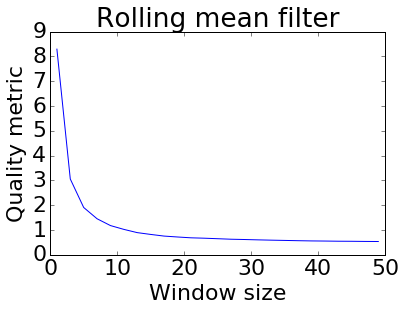

In [21]:
plt.title("Rolling mean filter")
plot_window(straight_line, create_rssi_avg_filter)

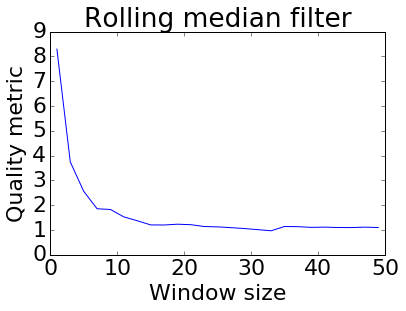

In [22]:
plt.title("Rolling median filter")
plot_window(straight_line, create_rssi_median_filter)

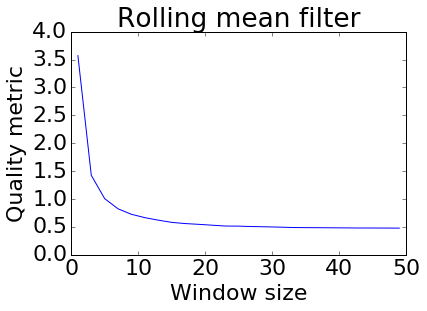

In [23]:
plt.title("Rolling mean filter")
plot_window(standing_still, create_rssi_avg_filter)

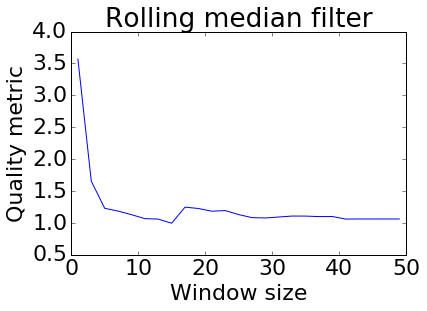

In [24]:
plt.title("Rolling median filter")
plot_window(standing_still, create_rssi_median_filter)

In [25]:
from sklearn.base import clone

In [94]:
def build_regression_map(rssi_df, img, regressor, preprocessor=None, figsize=(15, 10)):
    result = np.array([])
    unique_minors = sorted(rssi_df.Minor.unique())
    fig = plt.figure(figsize=figsize)
    for i, minor in enumerate(unique_minors):
        minor_df = rssi_df[rssi_df.Minor == minor]
        train_in = minor_df[['X','Y']].as_matrix()
        train_out = -minor_df[['RSSI']].as_matrix().ravel()
        if preprocessor:
            train_in = preprocessor.fit_transform(train_in)
        reg = clone(regressor)
        reg.fit(train_in, train_out)
        xy = np.mgrid[0:15:1, 0:-8:-1].reshape(2,-1).T
        test_in = np.mgrid[0:15:1, 0:-8:-1].reshape(2,-1).T
        if preprocessor:
            test_in = preprocessor.fit_transform(test_in)
        pred = reg.predict(test_in)
        if len(result) == 0:
            result = pred.reshape(-1, 1)
        else:
            result = np.hstack((result, pred.reshape(-1, 1)))
        ax = plt.subplot(int(np.ceil(len(unique_minors) / 3)), 3, 1 + i)
        plt.xticks([])
        plt.yticks([])
        ax.axis('off')
        ax.set_title(str(minor))
        plot_beacons(beacons[beacons.Minor == str(minor)], img)
        scatter_over_image(img, rssi_df.X, rssi_df.Y, c=-rssi_df.RSSI,
                           cmap='Greys',
                           vmax=-rssi_df.RSSI.min(),
                           vmin=-rssi_df.RSSI.max())
        
        scatter_over_image(img, xy[:, 0], -xy[:, 1], c=pred,
                           cmap='Greys',
                           vmax=-rssi_df.RSSI.min(),
                           vmin=-rssi_df.RSSI.max())
    return (result, xy)


In [76]:
from sklearn.neighbors import KNeighborsRegressor

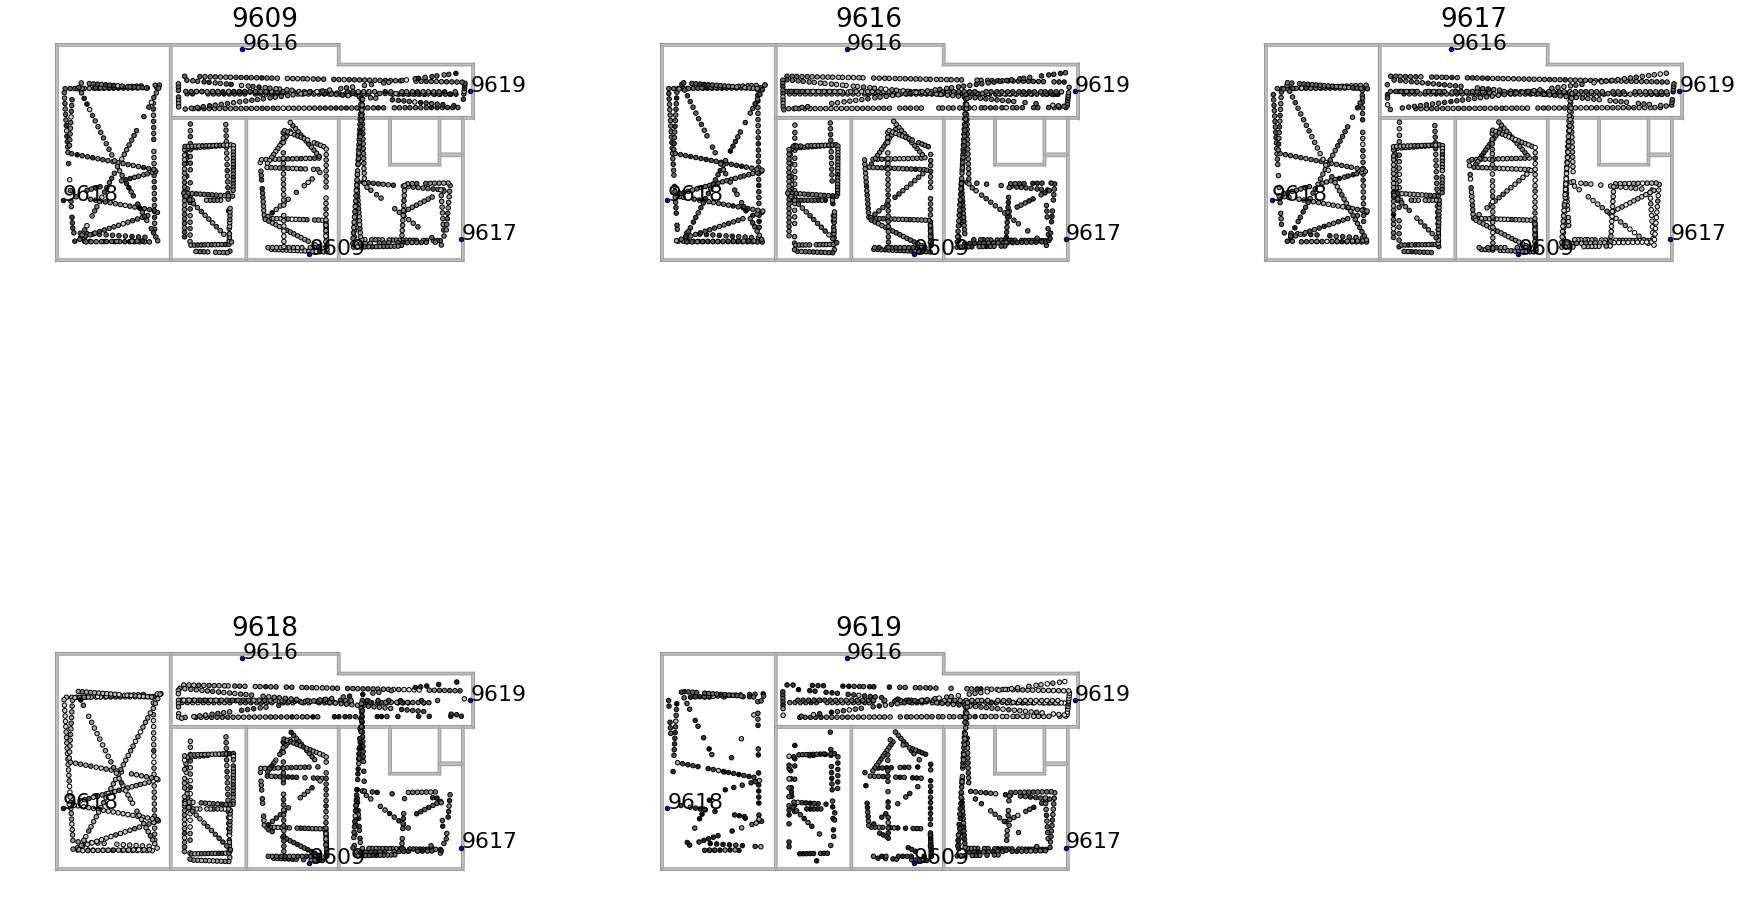

In [33]:
plot_rssi_map(df, img, beacons=beacons)

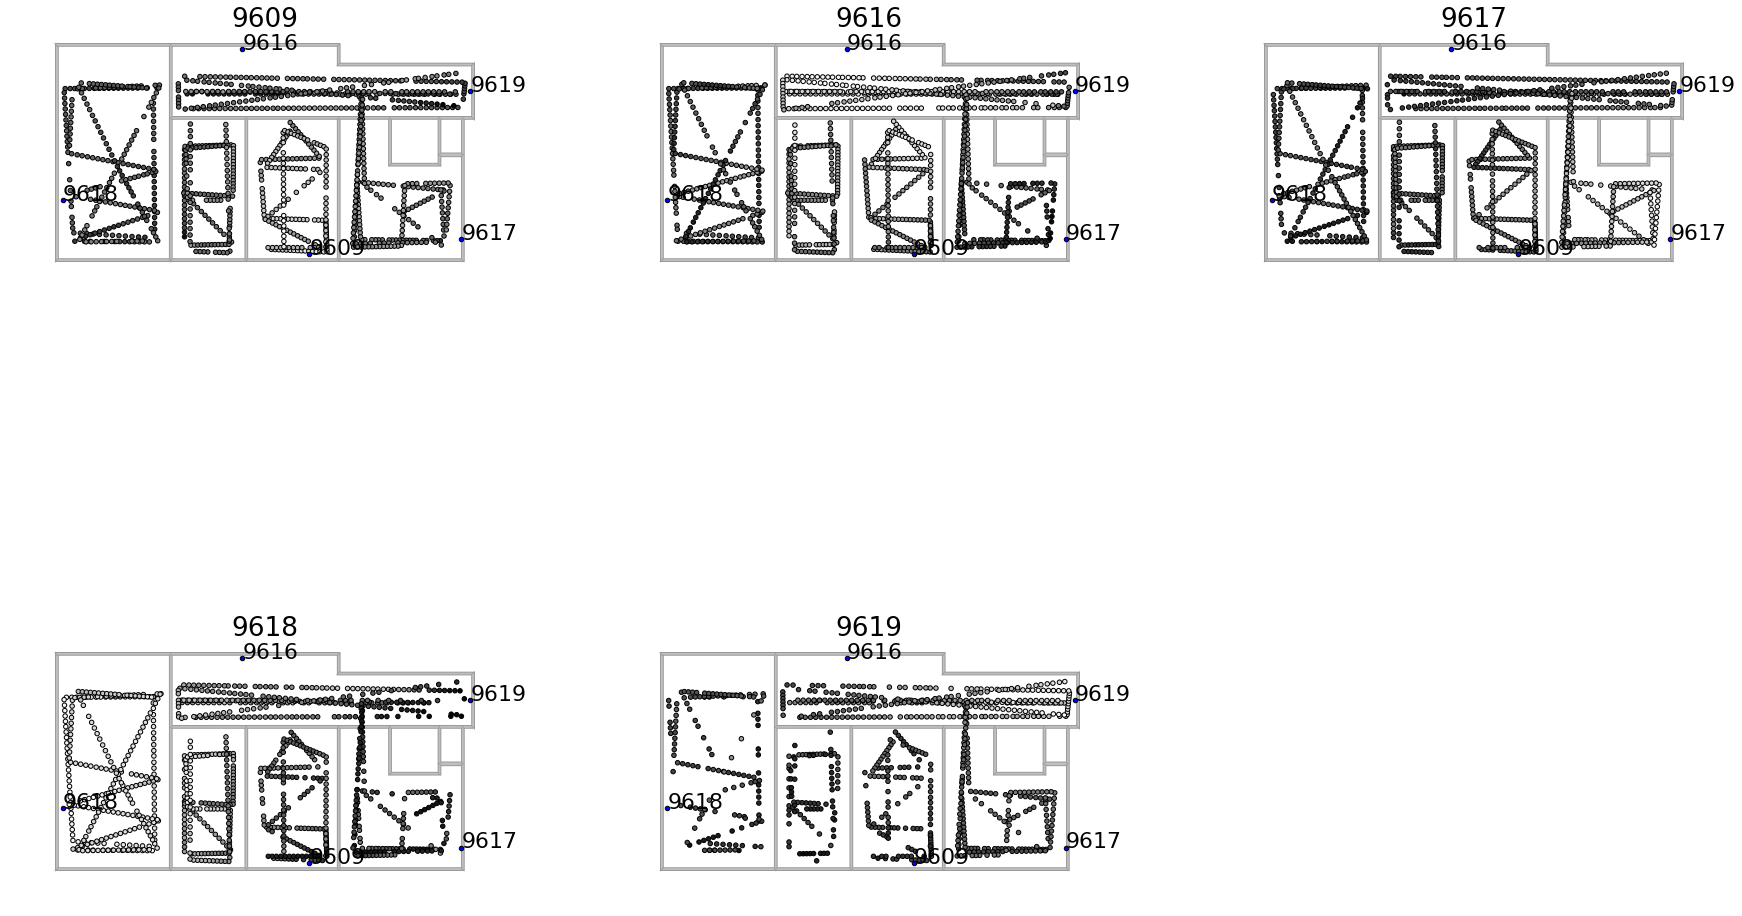

In [34]:
plot_rssi_map(filter_rssi_df(df, filter_func=create_rssi_avg_filter(17)), img, beacons=beacons)

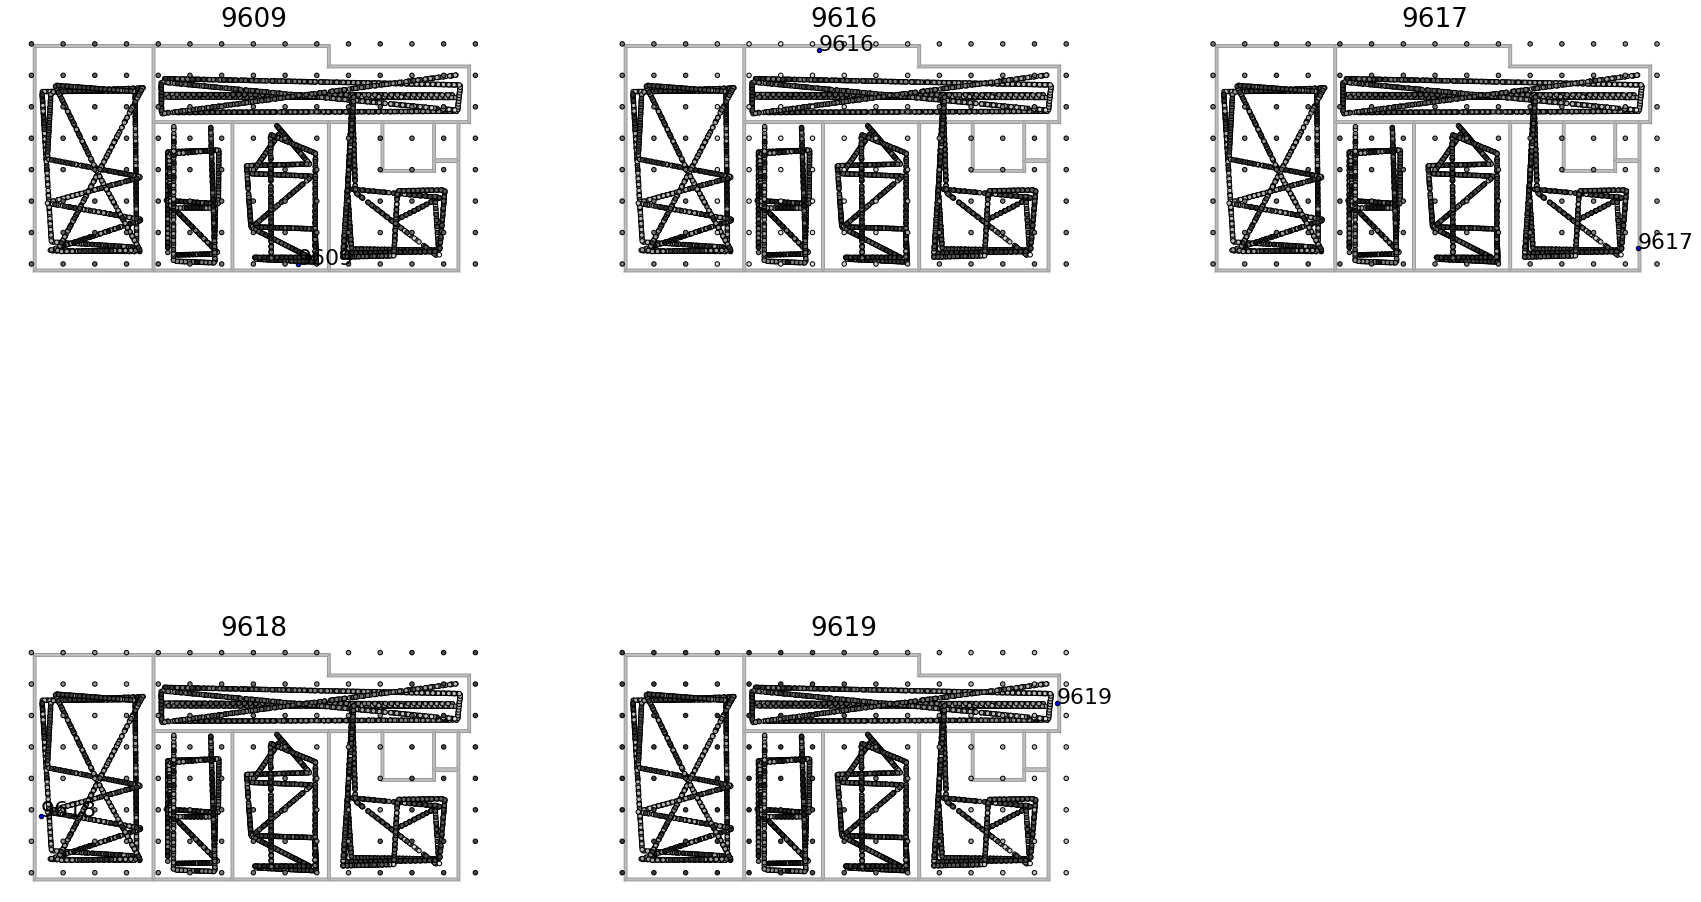

In [95]:
m, xy = build_regression_map(filter_rssi_df(df, filter_func=create_rssi_avg_filter(17)), img,
                             KNeighborsRegressor(n_neighbors=1),
                             figsize=(30, 20))

In [88]:
np.std(m[:, 0])

1.7407116836224525

In [87]:
np.std(m[:, 1])

7.7745764356589611

In [89]:
np.std(m[:, 2])

1.9311162291451853

In [91]:
np.std(m[:, 3])

4.7908605628199208

In [92]:
np.std(m[:, 4])

8.0325062906774161

In [90]:
m[:, 0]

array([ 81.2780912 ,  81.25004537,  80.96177435,  80.98854987,
        80.98801988,  80.98812599,  81.01758119,  81.01795868,
        80.78960127,  80.66965105,  80.81555867,  80.56927699,
        80.50499619,  80.50665096,  80.55422429,  80.55509557,
        80.62242772,  80.70244983,  80.75705413,  80.76686524,
        80.77701334,  80.77621894,  80.77580209,  80.47067117,
        80.51057221,  80.18044979,  80.24064463,  80.03702877,
        79.10987287,  79.02107422,  79.0200753 ,  78.80264297,
        79.25103878,  78.90780277,  78.42099671,  78.08421856,
        78.07992127,  77.66750452,  77.66549247,  77.66430283,
        77.53367736,  77.25463177,  77.2752396 ,  77.03644544,
        77.03714938,  76.77165607,  76.77149315,  76.77137294,
        76.51533472,  76.31305185,  76.3124097 ,  76.31217055,
        76.31205212,  76.31198343,  76.31193937,  76.31190907,
        75.95819626,  75.97073673,  75.97393451,  76.03884689,
        76.03980706,  76.04032336,  76.04062699,  76.04